## **Importing Python Libraries**

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install haversine
from haversine import haversine
!pip install cartopy
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
!pip install netcdf4
import xarray as xr
from scipy.interpolate import interp2d


## **Processing Functions**

Below are our main functions for data cleaning, indexing, interpolation, and plotting.

In [57]:
def load_data_drifter(type):
    if type == 7160:
        #loading White drifter with Anchor (7160) data into a dataframe
        data_frame=pd.read_csv('DR7160.txt',sep='\t',header=None)
        print(data_frame)
        header_names = ['Column1', 'drifter_name', 'drifter_name_dup', 'date_time', 'lat', 'long', 'condition']
        data_frame.columns = header_names
        #Cleaning unused data columns
        data_frame=data_frame.drop(['Column1','drifter_name','drifter_name_dup','condition'],axis=1)

    elif type == 9931:
        #loading White drifter with Anchor (9931) data into a dataframe
        data_frame=pd.read_csv('DR9931.txt',sep='\t',header=None)
        header_names = ['Column1', 'drifter_name', 'drifter_name_dup', 'date_time', 'lat', 'long', 'condition']
        data_frame.columns = header_names
        #Cleaning unused data columns
        data_frame=data_frame.drop(['Column1','drifter_name','drifter_name_dup','condition'],axis=1)

    elif type == 386:
        data_frame=pd.read_csv('LCF00386.txt',sep=',',header=None, skiprows = 1)
        header_names = ['date_time', 'reception_time', 'lat', 'long', 'speed', 'course', 'status', 'temp']
        data_frame.columns = header_names
        #Cleaning unused data columns
        data_frame=data_frame.drop(['reception_time','speed','course','status','temp'],axis=1)

    elif type == 277:
        data_frame=pd.read_csv('LCI00277.txt',sep=',',header=None, skiprows=1)
        header_names = ['date_time', 'reception_time', 'lat', 'long', 'speed', 'course', 'status','battery', 'temp']
        print(data_frame)
        data_frame.columns = header_names
        #Cleaning unused data columns
        data_frame=data_frame.drop(['reception_time','speed','course','status','battery','temp'],axis=1)
    else:
        print("\n\tVerify drifter type id\n")
        exit()

    print("\nData imported and frist clean performed")
    #print(White_withAnchor.head())
    return data_frame

def drifters (date, time_start, time_end,data_frame):

    #Converting time
    data_frame['Dates'] = pd.to_datetime(data_frame['date_time']).dt.date
    data_frame['Time'] = pd.to_datetime(data_frame['date_time']).dt.time
    print("\nDate and time properly separated")
    #print(White_withAnchor.head())

    #Cleaning unused data columns
    data_frame=data_frame.drop(['date_time'],axis=1)

    #Using only the data from the date 10/oct/2024
    data_frame_date = data_frame[data_frame['Dates'].astype(str) == date]
    print("\nData of ", date)

    #delete date as no longer needed
    data_frame_date=data_frame_date.drop(['Dates'],axis=1)
    print("\nDataset cleaned from date")

    #time filtering from time_start to time_end
    data_frame_date_time = data_frame_date[
        (data_frame_date['Time'] >= pd.to_datetime(time_start).time()) &
        (data_frame_date['Time'] <= pd.to_datetime(time_end).time())]
    print("\n Using the time of the drifter on water", time_start, " - ", time_end)

    #Equally spacing the data in the time
    # Resample the data to 30-minute intervals and interpolate missing values

    data_frame_date_time.set_index('Time', inplace=True)
    data_frame_date_time.index = pd.to_datetime(data_frame_date_time.index, format='%H:%M:%S')  # Adjust format as needed
    # Resampling data every 1 min
    data_frame_date_time_resampled  = data_frame_date_time.resample('1min').mean()
    # Interpolate missing values (linear interpolation by default)
    data_frame_date_time_resampled = data_frame_date_time_resampled.interpolate(method='linear')
    # Reset index to bring 'Datetime' back as a column if needed
    data_frame_date_time_resampled.reset_index(inplace=True)
    #delete the artificial date created
    data_frame_date_time_resampled['Time'] = pd.to_datetime(data_frame_date_time_resampled['Time']).dt.time
    print("\nResampled data every 1 mins")

    data_frame_date_time_resampled_with_vels = drifters_velocities(data_frame_date_time_resampled)
    return data_frame_date_time_resampled_with_vels


## Calculate instantaneous velocity
def drifters_velocities(data_frame):
    # Input longitude and latitudes
    longitudes = data_frame['long']
    latitudes = data_frame['lat']
    id_time = pd.to_datetime(data_frame['Time'],format='%H:%M:%S')

    # Initialize
    velocities = []

    # Iterate through the arrays to calculate instantaneous velocity using central difference method (centered at i)
    for i in range(1, len(longitudes) - 1):  # Skip first and last points
        # Get coordinates for points before and after the current time step
        point_prev = (latitudes[i - 1], longitudes[i - 1])
        point_next = (latitudes[i + 1], longitudes[i + 1])

        # Haversine distance in meters between (i-1) and (i+1)
        distance = haversine(point_prev, point_next) * 1000  # Convert km to m

        # Time difference between (i+1) and (i-1) in seconds
        time_diff = (id_time[i + 1] - id_time[i - 1]).total_seconds()

        # Calculate instantaneous velocity
        velocity = distance / time_diff

        # Append velocity to the list
        velocities.append(velocity)
    velocities.insert(0,0)
    velocities.append(0)

    data_frame['Velocities'] = velocities

    return data_frame


## plotting drifters position
def plot_drifter_positions(all_drifters, colors, labels, map_boundary,title):
    """
    Plots the positions of drifters on a map with a scatter plot.

    Parameters:
    - all_drifters: List of dictionaries containing drifter data, each with 'long', 'lat', and 'Velocities'.
    - colors: List of colors for each drifter.
    - labels: List of labels for each drifter.
    - map_boundary: The map boundary to zoom in on (default is the south of France).
    - title: Title of the plot.
    """
    # Create a map with Cartopy
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='grey')
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set boundaries for the zoomed-in area
    ax.set_extent(map_boundary, crs=ccrs.PlateCarree())

    # Loop through all drifters and plot them on the same map
    for drifter, color, label in zip(all_drifters, colors, labels):
        # Assuming drifter has attributes: `long`, `lat`, and `velocities`
        interpolated_long = drifter['long']
        interpolated_lat = drifter['lat']
        velocities = drifter['Velocities']

        # Normalize velocities for consistent scaling (optional, not used here)
        if len(interpolated_long) == len(interpolated_lat) and len(velocities) == len(interpolated_long):
            scatter = ax.scatter(
                interpolated_long,
                interpolated_lat,
                color=color,  # Use fixed color for the drifter
                marker='o',
                s=5,
                transform=ccrs.PlateCarree(),
                label=label
            )
        else:
            print(f"Error: Data lengths do not match for {label}")

    # Add gridlines with degree labels
    gridlines = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gridlines.xlabel_style = {'size': 8, 'color': 'red'}
    gridlines.ylabel_style = {'size': 8, 'color': 'red'}
    gridlines.xformatter = LongitudeFormatter(degree_symbol="°")
    gridlines.yformatter = LatitudeFormatter(degree_symbol="°")

    # Add title and labels
    ax.set_title(title)
    ax.text(-0.12, 0.55, 'Latitude (°)', va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform=ax.transAxes)
    ax.text(0.5, -0.1, 'Longitude (°)', va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', transform=ax.transAxes)
    ax.set_aspect('equal')

    # Add legend
    plt.legend()
    plt.show()


## plotting drifters speeds
def plot_drifters_speed(white_anchor, yellow_no_anchor, yellow_anchor,title,map_boundary,labels):
    # Create a more zoomed-in plot with velocity color coding
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set boundaries for a slightly more zoomed-in view
    ax.set_extent(map_boundary, crs=ccrs.PlateCarree())

    # Plot each drifter with velocity color coding and annotations
    scatter1 = ax.scatter(
        white_anchor['long'],
        white_anchor['lat'],
        c=white_anchor['Velocities'],
        cmap='inferno',
        marker='o',
        s=2,
        transform=ccrs.PlateCarree(),
        label=labels[0]
    )
    ax.annotate(
        'White Anchor',
        xy=(white_anchor['long'].iloc[-1], white_anchor['lat'].iloc[-1]),
        xytext=(white_anchor['long'].iloc[-1] + 0.005, white_anchor['lat'].iloc[-1] + 0.005),
        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='white')
    )

    scatter2 = ax.scatter(
        yellow_no_anchor['long'],
        yellow_no_anchor['lat'],
        c=yellow_no_anchor['Velocities'],
        cmap='inferno',
        marker='o',
        s=2,
        transform=ccrs.PlateCarree(),
        label=labels[1]
    )
    ax.annotate(
        'Yellow No Anchor',
        xy=(yellow_no_anchor['long'].iloc[-1], yellow_no_anchor['lat'].iloc[-1]),
        xytext=(yellow_no_anchor['long'].iloc[-1] - 0.002, yellow_no_anchor['lat'].iloc[-1] + 0.005),
        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white')
    )

    scatter3 = ax.scatter(
        yellow_anchor['long'],
        yellow_anchor['lat'],
        c=yellow_anchor['Velocities'],
        cmap='cividis',
        marker='o',
        s=2,
        transform=ccrs.PlateCarree(),
        label=labels[2]
    )
    ax.annotate(
        'Yellow Anchor',
        xy=(yellow_anchor['long'].iloc[-1], yellow_anchor['lat'].iloc[-1]),
        xytext=(yellow_anchor['long'].iloc[-1] - 0.005, yellow_anchor['lat'].iloc[-1] - 0.005),
        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='white')
    )

    # Add gridlines with degree labels
    gridlines = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gridlines.xlabel_style = {'size': 8, 'color': 'red'}
    gridlines.ylabel_style = {'size': 8, 'color': 'red'}
    gridlines.xformatter = LongitudeFormatter(degree_symbol="°")
    gridlines.yformatter = LatitudeFormatter(degree_symbol="°")

    # Set aspect to 'equal' for square aspect ratio
    ax.set_aspect('equal')

    # Labels and title
    ax.set_title(title)
    ax.text(-0.12, 0.55, 'Latitude (°)', va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform=ax.transAxes)
    ax.text(0.5, -0.1, 'Longitude (°)', va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', transform=ax.transAxes)

    # Add a colorbar for velocities
    cbar = plt.colorbar(scatter1, ax=ax, shrink=0.44, pad=0.1)
    cbar.set_label('Velocity')

    plt.show()



from matplotlib.colors import Normalize
def plot_drifter_positions_with_wind_subplot(
    all_drifters, colors, labels, map_boundary, title, wind_data,
    lat_min, lat_max, lon_min, lon_max, filename
):
    """
    Plots drifter positions and wind data in a two-panel subplot layout.

    Parameters:
    - all_drifters: List of dictionaries containing drifter data.
    - colors: List of colors for each drifter.
    - labels: List of labels for each drifter.
    - map_boundary: The map boundary for zooming in on the map.
    - title: Title of the plot.
    - wind_data: Wind data (quiver plot will be used).
    - lat_min, lat_max: Latitude range for wind data.
    - lon_min, lon_max: Longitude range for wind data.
    - filename: Filename for saving the plot.
    """
    # Create figure with 2 subplots
    fig, axes = plt.subplots(
        nrows=2, ncols=1, figsize=(15, 7),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # First subplot: Drifter positions
    ax1 = axes[0]
    ax1.coastlines()
    ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor='grey')
    ax1.add_feature(cfeature.BORDERS, linestyle=':')
    ax1.set_extent(map_boundary, crs=ccrs.PlateCarree())

    for drifter, color, label in zip(all_drifters, colors, labels):
        interpolated_long = drifter['long']
        interpolated_lat = drifter['lat']
        velocities = drifter['Velocities']

        if len(interpolated_long) == len(interpolated_lat) and len(velocities) == len(interpolated_long):
            ax1.scatter(
                interpolated_long, interpolated_lat, color=color, marker='o',
                s=5, transform=ccrs.PlateCarree(), label=label
            )
        else:
            print(f"Error: Data lengths do not match for {label}")

    ax1.annotate(
        'Deployment location',
        xy=(all_drifters[0]['long'][1], all_drifters[0]['lat'][1]),
        xytext=(all_drifters[0]['long'][1] + 0.0025, all_drifters[0]['lat'][1] + 0.005),
        arrowprops=dict(facecolor='black', shrink=0.04, width=1, headwidth=3),
        fontsize=8, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
    )

    gridlines = ax1.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gridlines.xlabel_style = {'size': 8, 'color': 'red'}
    gridlines.ylabel_style = {'size': 8, 'color': 'red'}
    gridlines.xformatter = LongitudeFormatter(degree_symbol="°")
    gridlines.yformatter = LatitudeFormatter(degree_symbol="°")

    ax1.legend()

    # Second subplot: Wind data
    ax2 = axes[1]
    ax2.coastlines()
    ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor='grey')
    ax2.add_feature(cfeature.BORDERS, linestyle=':')
    ax2.set_extent(map_boundary, crs=ccrs.PlateCarree())

    # Subset the wind data for the region of interest
    toulon_data = wind_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
    u_wind = toulon_data['u_wind'].isel(time=1, zlev=0).values
    v_wind = toulon_data['v_wind'].isel(time=1, zlev=0).values
    lat = toulon_data['lat'].values
    lon = toulon_data['lon'].values

    # Interpolation
    num_points = 100
    lat_fine = np.linspace(lat_min, lat_max, num_points)
    lon_fine = np.linspace(lon_min, lon_max, num_points)
    interp_u = interp2d(lon, lat, u_wind, kind='cubic')
    interp_v = interp2d(lon, lat, v_wind, kind='cubic')
    u_wind_fine = interp_u(lon_fine, lat_fine)
    v_wind_fine = interp_v(lon_fine, lat_fine)
    wind_speed = np.sqrt(u_wind_fine**2 + v_wind_fine**2)
    lon_grid_fine, lat_grid_fine = np.meshgrid(lon_fine, lat_fine)

    norm = Normalize(vmin=7.5, vmax=10)  # Adjust vmin and vmax as needed

    # Plot wind vectors
    # Create the quiver plot with normalized colors
    quiver = ax2.quiver(
        lon_grid_fine, lat_grid_fine, u_wind_fine, v_wind_fine, wind_speed,
        transform=ccrs.PlateCarree(), scale=50, pivot='middle', cmap='viridis',
        width=0.005, norm=norm  # Apply the normalization
    )

    # Add a colorbar
    cbar = plt.colorbar(
        quiver,
        ax=ax2,
        orientation='vertical',
        pad=0.01,
    )
    cbar.set_label('Wind Velocity [m/s]', rotation=-90, labelpad=15, size=10)

    # Loop through all drifters and plot them on the same map
    for drifter, color, label in zip(all_drifters, colors, labels):
        # Assuming drifter has attributes: `long`, `lat`, and `velocities`
        interpolated_long = drifter['long']
        interpolated_lat = drifter['lat']
        velocities = drifter['Velocities']

        # Normalize velocities for consistent scaling (optional, not used here)
        if len(interpolated_long) == len(interpolated_lat) and len(velocities) == len(interpolated_long):
            scatter = ax2.scatter(
                interpolated_long,
                interpolated_lat,
                color=color,  # Use fixed color for the drifter
                marker='o',
                s=5,
                transform=ccrs.PlateCarree(),
                label=label
            )
        else:
            print(f"Error: Data lengths do not match for {label}")

    # Add gridlines with degree labels
    gridlines = ax2.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gridlines.xlabel_style = {'size': 8, 'color': 'red'}
    gridlines.ylabel_style = {'size': 8, 'color': 'red'}
    gridlines.xformatter = LongitudeFormatter(degree_symbol="°")
    gridlines.yformatter = LatitudeFormatter(degree_symbol="°")

    # Add title and labels
    ax2.text(0.12, 0.55, 'Latitude [°]', size=12, va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform=ax2.transAxes)
    ax2.text(0.6, -0.1, 'Longitude [°]', size=12, va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', transform=ax2.transAxes)
    ax2.set_aspect('equal')
    # Get the current position of ax2
    pos = ax2.get_position().bounds  # (x0, y0, width, height)

    # Adjust the x-coordinate (x0) to shift left
    new_pos = [pos[0] - 0.08, pos[1], pos[2], pos[3]]  # Decrease x0 by 0.02

    # Apply the new position to ax2
    ax2.set_position(new_pos)



    # Overall title
    fig.suptitle(title, fontsize=16)

    # Save the figure
    plt.savefig(filename, dpi=300)
    plt.show()



## plotting drifters position
def plot_drifter_positions_annotation(all_drifters, colors, labels, map_boundary,title):
    """
    Plots the positions of drifters on a map with a scatter plot.

    Parameters:
    - all_drifters: List of dictionaries containing drifter data, each with 'long', 'lat', and 'Velocities'.
    - colors: List of colors for each drifter.
    - labels: List of labels for each drifter.
    - map_boundary: The map boundary to zoom in on (default is the south of France).
    - title: Title of the plot.
    """
    # Create a map with Cartopy
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='grey')
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set boundaries for the zoomed-in area
    ax.set_extent(map_boundary, crs=ccrs.PlateCarree())

    # Loop through all drifters and plot them on the same map
    for drifter, color, label in zip(all_drifters, colors, labels):
        # Assuming drifter has attributes: `long`, `lat`, and `velocities`
        interpolated_long = drifter['long']
        interpolated_lat = drifter['lat']
        velocities = drifter['Velocities']

        # Normalize velocities for consistent scaling (optional, not used here)
        if len(interpolated_long) == len(interpolated_lat) and len(velocities) == len(interpolated_long):
            scatter = ax.scatter(
                interpolated_long,
                interpolated_lat,
                color=color,  # Use fixed color for the drifter
                marker='o',
                s=5,
                transform=ccrs.PlateCarree(),
                label=label
            )

        else:
            print(f"Error: Data lengths do not match for {label}")


    # Annotation deployment position
    ax.annotate(
    'Deployment location',
    xy=(drifter['long'].iloc[1], drifter['lat'].iloc[1]),
    xytext=(drifter['long'].iloc[1] + 0.0025, drifter['lat'].iloc[1] + 0.005),
    arrowprops=dict(facecolor='black', shrink=0.04, width=1, headwidth=3),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
)

    # Add gridlines with degree labels
    gridlines = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gridlines.xlabel_style = {'size': 8, 'color': 'red'}
    gridlines.ylabel_style = {'size': 8, 'color': 'red'}
    gridlines.xformatter = LongitudeFormatter(degree_symbol="°")
    gridlines.yformatter = LatitudeFormatter(degree_symbol="°")

    # Add title and labels
    ax.set_title(title)
    ax.text(-0.12, 0.55, 'Latitude (°)', va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform=ax.transAxes)
    ax.text(0.5, -0.1, 'Longitude (°)', va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', transform=ax.transAxes)
    ax.set_aspect('equal')

    # Add legend
    plt.legend()
    plt.show()








## **16/10/2024 Data**

In [58]:
print("\n\tHola!!\n")

white_anchor_16 = drifters('2024-10-16','08:51:00', '10:53:00', load_data_drifter(7160))

yellow_no_anchor_16 = drifters('2024-10-16','08:51:00','10:45:00',load_data_drifter(277))

yellow_anchor_16 = drifters('2024-10-16','08:51:00','10:33:00',load_data_drifter(386))

all_drifters_16=[white_anchor_16,yellow_no_anchor_16,yellow_anchor_16]
#BYE BYE BYE
print("\n\tBYEEE\n")


	Hola!!

            0          1                      2                    3  \
0    57787799  0-4407160  0-4407160  (70621208)  2024-10-18 10:57:42   
1    57787795  0-4407160  0-4407160  (70621208)  2024-10-18 10:52:41   
2    57787782  0-4407160  0-4407160  (70621208)  2024-10-18 10:48:45   
3    57787766  0-4407160  0-4407160  (70621208)  2024-10-18 10:44:45   
4    57787734  0-4407160  0-4407160  (70621208)  2024-10-18 10:39:43   
..        ...        ...                    ...                  ...   
123  57736190  0-4407160  0-4407160  (70621208)  2024-10-15 07:39:14   
124  57736176  0-4407160  0-4407160  (70621208)  2024-10-15 07:34:11   
125  57736155  0-4407160  0-4407160  (70621208)  2024-10-15 07:29:13   
126  57736150  0-4407160  0-4407160  (70621208)  2024-10-15 07:24:09   
127  57736127  0-4407160  0-4407160  (70621208)  2024-10-15 07:19:09   

            4        5     6  
0    43.07228  5.98763  GOOD  
1    43.07478  5.98497  GOOD  
2    43.07726  5.98375  GOOD  
3

## 15-10-2024 Data

In [59]:
print("\n\tHola!!\n")
white_anchor_15 = drifters('2024-10-15','10:06:00','11:41:00', load_data_drifter(7160))

yellow_no_anchor_15 = drifters('2024-10-15','10:06:00','11:34:00',load_data_drifter(277))

yellow_anchor_15 = drifters('2024-10-15','09:41:00','11:20:00',load_data_drifter(386))

all_drifters_15=[white_anchor_15,yellow_no_anchor_15,yellow_anchor_15]
#BYE BYE BYE
print("\n\tBYEEE\n")


	Hola!!

            0          1                      2                    3  \
0    57787799  0-4407160  0-4407160  (70621208)  2024-10-18 10:57:42   
1    57787795  0-4407160  0-4407160  (70621208)  2024-10-18 10:52:41   
2    57787782  0-4407160  0-4407160  (70621208)  2024-10-18 10:48:45   
3    57787766  0-4407160  0-4407160  (70621208)  2024-10-18 10:44:45   
4    57787734  0-4407160  0-4407160  (70621208)  2024-10-18 10:39:43   
..        ...        ...                    ...                  ...   
123  57736190  0-4407160  0-4407160  (70621208)  2024-10-15 07:39:14   
124  57736176  0-4407160  0-4407160  (70621208)  2024-10-15 07:34:11   
125  57736155  0-4407160  0-4407160  (70621208)  2024-10-15 07:29:13   
126  57736150  0-4407160  0-4407160  (70621208)  2024-10-15 07:24:09   
127  57736127  0-4407160  0-4407160  (70621208)  2024-10-15 07:19:09   

            4        5     6  
0    43.07228  5.98763  GOOD  
1    43.07478  5.98497  GOOD  
2    43.07726  5.98375  GOOD  
3

## 18-10-2024 Data

In [60]:
print("\n\tHola!!\n")

white_anchor_18= drifters('2024-10-18','09:18:00', '10:49:00', load_data_drifter(7160))

white_no_anchor_18= drifters('2024-10-18','09:18:00','11:02:00',load_data_drifter(9931))

yellow_anchor_18= drifters('2024-10-18','09:18:00','10:49:00',load_data_drifter(386))

all_drifters_18=[white_anchor_18,white_no_anchor_18,yellow_anchor_18]
#BYE BYE BYE
print("\n\tBYEEE\n")


	Hola!!

            0          1                      2                    3  \
0    57787799  0-4407160  0-4407160  (70621208)  2024-10-18 10:57:42   
1    57787795  0-4407160  0-4407160  (70621208)  2024-10-18 10:52:41   
2    57787782  0-4407160  0-4407160  (70621208)  2024-10-18 10:48:45   
3    57787766  0-4407160  0-4407160  (70621208)  2024-10-18 10:44:45   
4    57787734  0-4407160  0-4407160  (70621208)  2024-10-18 10:39:43   
..        ...        ...                    ...                  ...   
123  57736190  0-4407160  0-4407160  (70621208)  2024-10-15 07:39:14   
124  57736176  0-4407160  0-4407160  (70621208)  2024-10-15 07:34:11   
125  57736155  0-4407160  0-4407160  (70621208)  2024-10-15 07:29:13   
126  57736150  0-4407160  0-4407160  (70621208)  2024-10-15 07:24:09   
127  57736127  0-4407160  0-4407160  (70621208)  2024-10-15 07:19:09   

            4        5     6  
0    43.07228  5.98763  GOOD  
1    43.07478  5.98497  GOOD  
2    43.07726  5.98375  GOOD  
3

# Code for additional analysis (subplots, wind data, error analysis, etc).

## Wind Data

In [61]:
# Load in wind data (Copernicus Global Ocean Daily Gridded Sea Surface Winds from Scatterometer)
wind_data = xr.open_dataset('NBSv02_wind_6hourly_20241016.nc', engine='netcdf4')
wind_data15 = xr.open_dataset('NBSv02_wind_6hourly_20241015.nc', engine='netcdf4')
# Check data
print(wind_data.head())


<xarray.Dataset> Size: 2kB
Dimensions:  (time: 4, zlev: 1, lat: 5, lon: 5)
Coordinates:
  * time     (time) datetime64[ns] 32B 2024-10-16 ... 2024-10-16T18:00:00
  * zlev     (zlev) float32 4B 10.0
  * lat      (lat) float32 20B -89.75 -89.5 -89.25 -89.0 -88.75
  * lon      (lon) float32 20B 0.0 0.25 0.5 0.75 1.0
Data variables:
    crs      float64 8B ...
    mask     (time, zlev, lat, lon) float64 800B ...
    u_wind   (time, zlev, lat, lon) float32 400B ...
    v_wind   (time, zlev, lat, lon) float32 400B ...
Attributes: (12/57)
    Conventions:                   CF-1.7, ACDD-1.3
    title:                         NOAA/NCEI Blended 6-hourly 0.25-degree Sea...
    summary:                       This netCDF file  contains 0.25-degree glo...
    references:                    https://www.ncdc.noaa.gov/data-access/mari...
    institution:                   NOAA/NCEI
    license:                       These data are publically available for us...
    ...                            ...
  

<ipython-input-62-a35016bc9f71>:25: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interp_u = interp2d(lon, lat, u_wind16, kind='cubic')
<ipython-input-62-a35016bc9f71>:26: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or


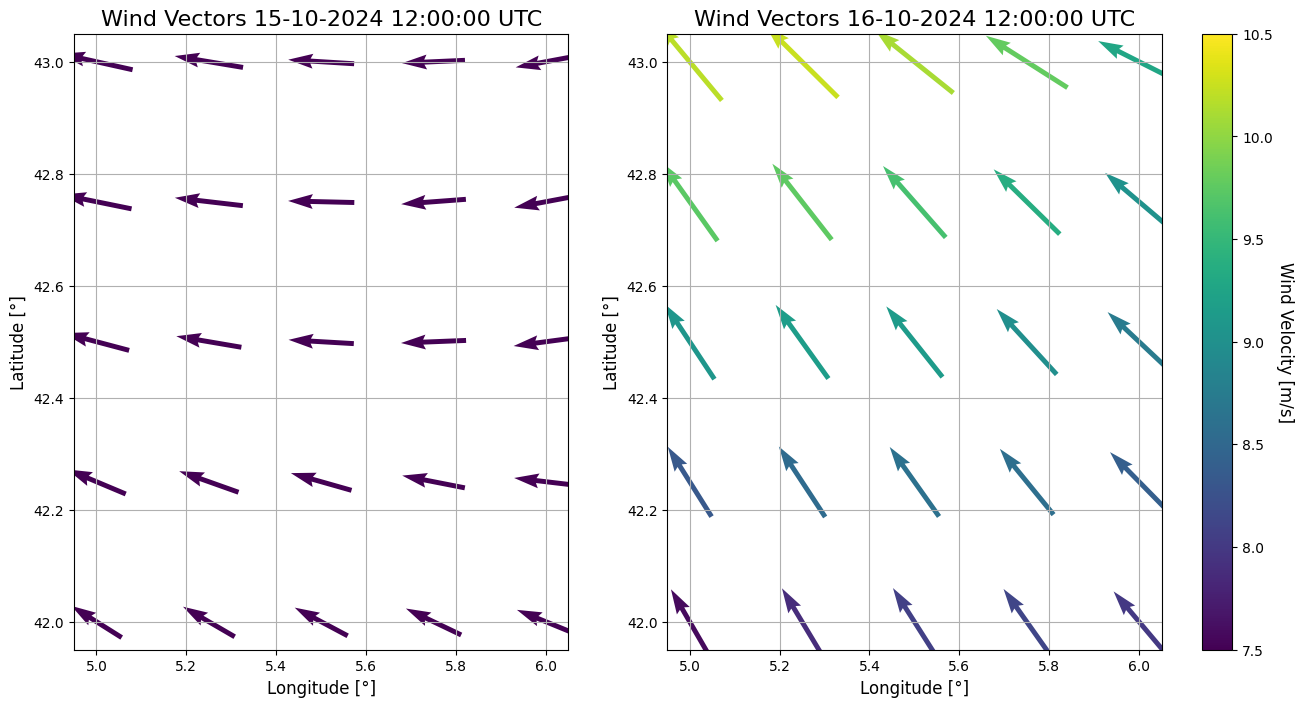

In [62]:

# Define bounds for Toulon Bay (adjust as needed)
lat_min, lat_max = 42, 43.11  # Latitude range
lon_min, lon_max = 5, 6  # Longitude range
## 16-10-2024
# Subset the dataset for the region of interest
toulon_data16 = wind_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))


# Extract wind components (selecting second time slice and surface level zlev)
u_wind16 = toulon_data16['u_wind'].isel(time=2, zlev=0).values  # Convert to numpy array
v_wind16 = toulon_data16['v_wind'].isel(time=2, zlev=0).values  # Convert to numpy array

# Calculate wind speed (magnitude)
wind_speed16 = np.sqrt(u_wind16**2 + v_wind16**2)

lat = toulon_data16['lat'].values
lon = toulon_data16['lon'].values

lon_grid16, lat_grid16 = np.meshgrid(lon, lat)

# Interpolation
num_points = 100
lat_fine16 = np.linspace(lat_min, lat_max, num_points)
lon_fine16 = np.linspace(lon_min, lon_max, num_points)
interp_u = interp2d(lon, lat, u_wind16, kind='cubic')
interp_v = interp2d(lon, lat, v_wind16, kind='cubic')
u_wind_fine16 = interp_u(lon_fine16, lat_fine16)
v_wind_fine16 = interp_v(lon_fine16, lat_fine16)
wind_speed_fine16 = np.sqrt(u_wind_fine16**2 + v_wind_fine16**2)
lon_grid_fine16, lat_grid_fine16 = np.meshgrid(lon_fine16, lat_fine16)


## 15-10-2024
# Subset the dataset for the region of interest
toulon_data15 = wind_data15.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))


# Extract wind components (selecting second time slice and surface level zlev)
u_wind15 = toulon_data15['u_wind'].isel(time=2, zlev=0).values  # Convert to numpy array
v_wind15 = toulon_data15['v_wind'].isel(time=2, zlev=0).values  # Convert to numpy array

# Calculate wind speed (magnitude)
wind_speed15 = np.sqrt(u_wind15**2 + v_wind15**2)

lat = toulon_data15['lat'].values
lon = toulon_data15['lon'].values

lon_grid15, lat_grid15 = np.meshgrid(lon, lat)

# Interpolation
num_points = 100
lat_fine15 = np.linspace(lat_min, lat_max, num_points)
lon_fine15 = np.linspace(lon_min, lon_max, num_points)
interp_u = interp2d(lon, lat, u_wind15, kind='cubic')
interp_v = interp2d(lon, lat, v_wind15, kind='cubic')
u_wind_fine15 = interp_u(lon_fine15, lat_fine15)
v_wind_fine15 = interp_v(lon_fine15, lat_fine15)
wind_speed_fine15 = np.sqrt(u_wind_fine15**2 + v_wind_fine15**2)
lon_grid_fine15, lat_grid_fine15 = np.meshgrid(lon_fine15, lat_fine15)



import matplotlib.pyplot as plt

# Define the minimum and maximum values for the colorbar
vmin = 7.5  # Minimum wind speed
vmax = 10.5  # Maximum wind speed

# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Plot data on each subplot
q1 = axs[0].quiver(lon_grid15, lat_grid15, u_wind15, v_wind15, wind_speed15, scale=50, pivot='middle', cmap='viridis', width=0.01,
                   clim=[vmin, vmax])
axs[0].set_title('Wind Vectors 15-10-2024 12:00:00 UTC', size=16)
# Set labels
axs[0].set_xlabel('Longitude [°]', size=12)
axs[0].set_ylabel('Latitude [°]', size=12)

# Enable grid
axs[0].grid(True)

# Plot data on each subplot
q2 = axs[1].quiver(lon_grid16, lat_grid16, u_wind16, v_wind16, wind_speed16, scale=50, pivot='middle', cmap='viridis', width=0.01,
                   clim=[vmin, vmax])
axs[1].set_title('Wind Vectors 16-10-2024 12:00:00 UTC', size=16)
# Set labels
axs[1].set_xlabel('Longitude [°]', size=12)
axs[1].set_ylabel('Latitude [°]', size=12)

# Enable grid
axs[1].grid(True)

# Create a single colorbar that applies to both quiver plots
cbar = fig.colorbar(q2, ax=axs, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('Wind Velocity [m/s]', rotation=-90, labelpad=15, size=12)

# Adjust layout to make space for the colorbar
plt.subplots_adjust(right=0.85)  # Increase the right margin for the colorbar

# Save the figure with high dpi
plt.savefig('winddata', dpi=300, bbox_inches='tight')
plt.show()

In [63]:
## Calculate mean of wind speed in designated area

# Define map boundary (lon min, lon max, lat min, lat max)
map_boundary = [5.94, 6.03, 43.07, 43.11]
lon_min, lon_max, lat_min, lat_max = map_boundary

# Find indices for latitudes and longitudes within the boundary
lat_indices_16 = np.where((lat_fine16 >= lat_min) & (lat_fine16 <= lat_max))[0]
lon_indices_16 = np.where((lon_fine16 >= lon_min) & (lon_fine16 <= lon_max))[0]

lat_indices_15 = np.where((lat_fine15 >= lat_min) & (lat_fine15 <= lat_max))[0]
lon_indices_15 = np.where((lon_fine15 >= lon_min) & (lon_fine15 <= lon_max))[0]

# Extract the subset of wind_speed_fine16 and wind_speed_fine15 within the boundary
wind_speed_fine16_roi = wind_speed_fine16[lat_indices_16[:, None], lon_indices_16]
wind_speed_fine15_roi = wind_speed_fine15[lat_indices_15[:, None], lon_indices_15]

# Compute the mean wind speed within the region, omitting NaNs
mean_wind_speed_fine16 = np.nanmean(wind_speed_fine16_roi)
mean_wind_speed_fine15 = np.nanmean(wind_speed_fine15_roi)

print(f"Mean wind speed for 16-10-2024 (excluding NaNs): {mean_wind_speed_fine16} m/s")
print(f"Mean wind speed for 15-10-2024 (excluding NaNs): {mean_wind_speed_fine15} m/s")



Mean wind speed for 16-10-2024 (excluding NaNs): 9.331828075271135 m/s
Mean wind speed for 15-10-2024 (excluding NaNs): 6.217087048957907 m/s


In [64]:

## plotting drifters position
def plot_drifter_positions_wind(all_drifters, colors, labels, map_boundary,title,wind_data,lat_min,lat_max,lon_min,lon_max,filename):
    """
    Plots the positions of drifters on a map with a scatter plot.

    Parameters:
    - all_drifters: List of dictionaries containing drifter data, each with 'long', 'lat', and 'Velocities'.
    - colors: List of colors for each drifter.
    - labels: List of labels for each drifter.
    - map_boundary: The map boundary to zoom in on (default is the south of France).
    - title: Title of the plot.
    """

    # Subset the wind data for the region of interest
    toulon_data = wind_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
    u_wind = toulon_data['u_wind'].isel(time=2, zlev=0).values
    v_wind = toulon_data['v_wind'].isel(time=2, zlev=0).values
    lat = toulon_data['lat'].values
    lon = toulon_data['lon'].values

    # Interpolation
    num_points = 100
    lat_fine = np.linspace(lat_min, lat_max, num_points)
    lon_fine = np.linspace(lon_min, lon_max, num_points)
    interp_u = interp2d(lon, lat, u_wind, kind='cubic')
    interp_v = interp2d(lon, lat, v_wind, kind='cubic')
    u_wind_fine = interp_u(lon_fine, lat_fine)
    v_wind_fine = interp_v(lon_fine, lat_fine)
    wind_speed = np.sqrt(u_wind_fine**2 + v_wind_fine**2)
    lon_grid_fine, lat_grid_fine = np.meshgrid(lon_fine, lat_fine)


     # Create a map with Cartopy
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.coastlines()
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='grey')
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set boundaries for the zoomed-in area
    ax.set_extent(map_boundary, crs=ccrs.PlateCarree())

    # Plot wind vectors
    quiver = ax.quiver(
        lon_grid_fine, lat_grid_fine, u_wind_fine, v_wind_fine, wind_speed,
        transform=ccrs.PlateCarree(), scale=50, pivot='middle', cmap='viridis', width=0.005
    )
    #cbar = plt.colorbar(quiver, ax=ax, orientation='vertical', pad=0.02, shrink=0.5, label='Wind Speed (m/s)')
    cbar = plt.colorbar(
        quiver,
        ax=ax,
        orientation='vertical',
        pad=0.105,  # Adjusts the space between the colorbar and the plot
        shrink=0.3,  # Shrinks the height of the colorbar for better alignment,
    )
    cbar.set_label('Velocity [m/s]', rotation=-90, labelpad=15, size = 9)

    # Loop through all drifters and plot them on the same map
    for drifter, color, label in zip(all_drifters, colors, labels):
        # Assuming drifter has attributes: `long`, `lat`, and `velocities`
        interpolated_long = drifter['long']
        interpolated_lat = drifter['lat']
        velocities = drifter['Velocities']

        # Normalize velocities for consistent scaling (optional, not used here)
        if len(interpolated_long) == len(interpolated_lat) and len(velocities) == len(interpolated_long):
            scatter = ax.scatter(
                interpolated_long,
                interpolated_lat,
                color=color,  # Use fixed color for the drifter
                marker='o',
                s=5,
                transform=ccrs.PlateCarree(),
                label=label
            )
        else:
            print(f"Error: Data lengths do not match for {label}")

    # Add gridlines with degree labels
    gridlines = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gridlines.xlabel_style = {'size': 7, 'color': 'red'}
    gridlines.ylabel_style = {'size': 7, 'color': 'red'}
    gridlines.xformatter = LongitudeFormatter(degree_symbol="°")
    gridlines.yformatter = LatitudeFormatter(degree_symbol="°")

    # Add title and labels
    ax.set_title(title, size = 16)
    ax.text(-0.12, 0.55, 'Latitude [°]', size=9, va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform=ax.transAxes)
    ax.text(0.5, -0.1, 'Longitude [°]', size=9, va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', transform=ax.transAxes)
    ax.set_aspect('equal')

    # Add legend
    plt.legend()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()



## **Data for No. 386 (Yellow No Anchor)**

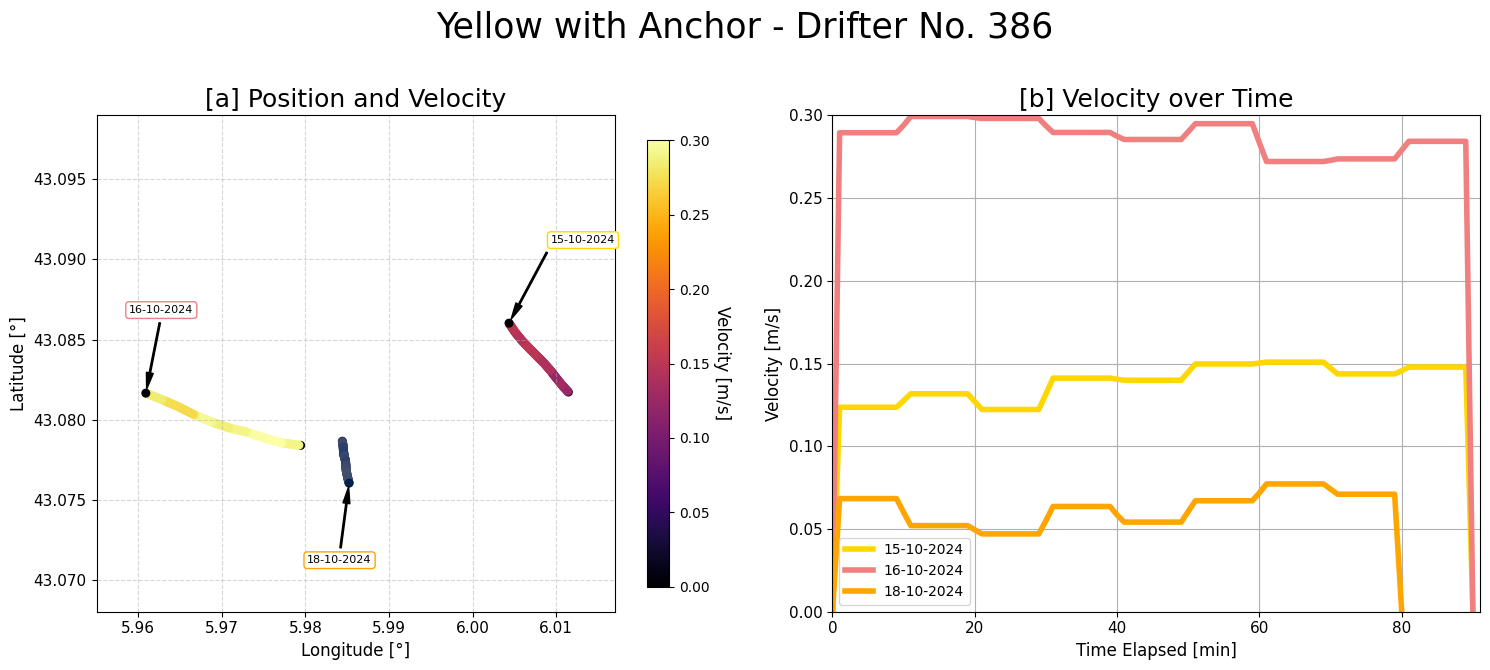

In [65]:
## Create velocity subplots
# Define plot parameters
title = 'Yellow with Anchor - Drifter No. 386'
map_boundary = [5.955, 6.017, 43.068, 43.099]

# Create subplots: one for the map plot and one for the velocity plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))  # Adjust size as needed

# Add a suptitle (overall title)
fig.suptitle(title, fontsize=25, y=0.95)  # Adjust `fontsize` and `y` (vertical position) as needed

# Map Plot (ax1)
# Set the boundaries for the map (just using latitude and longitude for regular plots)
ax1.set_xlim(map_boundary[0], map_boundary[1])
ax1.set_ylim(map_boundary[2], map_boundary[3])

# Plot each drifter's positions with color coding based on velocity
scatter1 = ax1.scatter(
    yellow_anchor_15['long'],
    yellow_anchor_15['lat'],
    c=yellow_anchor_15['Velocities'],
    cmap='inferno',
    marker='o',
    s=30,
    vmin = 0,
    vmax = 0.3
)
ax1.annotate(
    '15-10-2024',
    xy=(yellow_anchor_15['long'].iloc[-1], yellow_anchor_15['lat'].iloc[-1]),
    xytext=(yellow_anchor_15['long'].iloc[-1] + 0.005, yellow_anchor_15['lat'].iloc[-1] + 0.005),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='gold', facecolor='white')
)

scatter2 = ax1.scatter(
    yellow_anchor_16['long'],
    yellow_anchor_16['lat'],
    c=yellow_anchor_16['Velocities'],
    cmap='inferno',
    marker='o',
    s=30,
    vmin = 0,
    vmax = 0.3
)
ax1.annotate(
    '16-10-2024',
    xy=(yellow_anchor_16['long'].iloc[-1], yellow_anchor_16['lat'].iloc[-1]),
    xytext=(yellow_anchor_16['long'].iloc[-1] - 0.002, yellow_anchor_16['lat'].iloc[-1] + 0.005),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='lightcoral', facecolor='white')
)

scatter3 = ax1.scatter(
    yellow_anchor_18['long'],
    yellow_anchor_18['lat'],
    c=yellow_anchor_18['Velocities'],
    cmap='cividis',
    marker='o',
    s=30,
    vmin = 0,
    vmax = 0.3
)
ax1.annotate(
    '18-10-2024',
    xy=(yellow_anchor_18['long'].iloc[-1], yellow_anchor_18['lat'].iloc[-1]),
    xytext=(yellow_anchor_18['long'].iloc[-1] - 0.005, yellow_anchor_18['lat'].iloc[-1] - 0.005),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='orange', facecolor='white')
)

# Add gridlines and labels for the map
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.tick_params(axis='both', which='major', labelsize=11)  # Adjust major tick label size
ax1.set_xlabel('Longitude [°]', size = 12)
ax1.set_ylabel('Latitude [°]', size = 12)
ax1.set_title('[a] Position and Velocity', size = 18)

# Add a colorbar for the velocities
cbar = fig.colorbar(scatter1, ax=ax1, shrink=0.9, pad=0.05)
cbar.set_label('Velocity [m/s]', rotation=-90, labelpad=15, size = 12)

# Velocity Plot (ax2)
# Prepare the velocity time data
index_array_yellowanchor15 = np.arange(len(yellow_anchor_15['Time']))
index_array_yellowanchor16 = np.arange(len(yellow_anchor_16['Time']))
index_array_yellowanchor18 = np.arange(len(yellow_anchor_18['Time']))

# Find the length of each array
len_yellowanchor15 = len(yellow_anchor_15['Time'])
len_yellowanchor16= len(yellow_anchor_16['Time'])
len_yellowanchor18= len(yellow_anchor_18['Time'])

# Compare lengths
max_length = max(len_yellowanchor15, len_yellowanchor16,len_yellowanchor18)


ax2.plot(index_array_yellowanchor15, yellow_anchor_15['Velocities'], linewidth = 4, color = 'gold', label='15-10-2024')
ax2.plot(index_array_yellowanchor16, yellow_anchor_16['Velocities'], linewidth = 4, color = 'lightcoral', label='16-10-2024')
ax2.plot(index_array_yellowanchor18, yellow_anchor_18['Velocities'], linewidth = 4, color = 'orange',label='18-10-2024')
ax2.tick_params(axis='both', which='major', labelsize=11)  # Adjust major tick label size
ax2.set_xlabel('Time Elapsed [min]', size = 12)
ax2.set_ylabel('Velocity [m/s]', size = 12)
ax2.set_title('[b] Velocity over Time', size = 18)
ax2.set_xlim(0, max_length)
ax2.set_ylim(0, 0.3)
ax2.grid(True)
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the suptitle
plt.savefig('yellowwithanchor', dpi=300, bbox_inches='tight')
plt.show()



## **Data for No. 7160 (White with Anchor)**

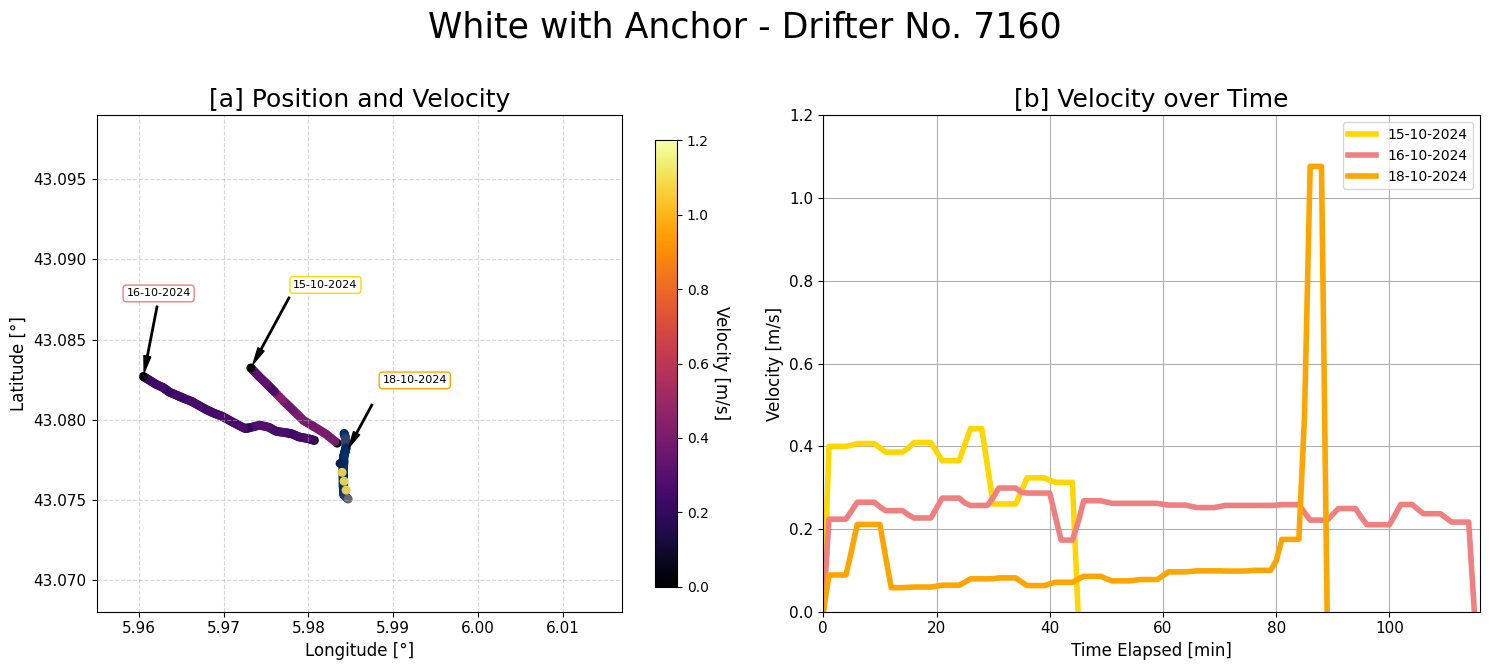

In [66]:
## Create velocity subplots
# Define plot parameters
title = 'White with Anchor - Drifter No. 7160'
map_boundary = [5.955, 6.017, 43.068, 43.099]

# Create subplots: one for the map plot and one for the velocity plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))  # Adjust size as needed

# Add a suptitle (overall title)
fig.suptitle(title, fontsize=25, y=0.95)  # Adjust `fontsize` and `y` (vertical position) as needed

# Map Plot (ax1)
# Set the boundaries for the map (just using latitude and longitude for regular plots)
ax1.set_xlim(map_boundary[0], map_boundary[1])
ax1.set_ylim(map_boundary[2], map_boundary[3])

# Plot each drifter's positions with color coding based on velocity
scatter1 = ax1.scatter(
    white_anchor_15['long'],
    white_anchor_15['lat'],
    c=white_anchor_15['Velocities'],
    cmap='inferno',
    marker='o',
    s=30,
    vmin = 0,
    vmax = 1.2
)
ax1.annotate(
    '15-10-2024',
    xy=(white_anchor_15['long'].iloc[-1], white_anchor_15['lat'].iloc[-1]),
    xytext=(white_anchor_15['long'].iloc[-1] + 0.005, white_anchor_15['lat'].iloc[-1] + 0.005),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='gold', facecolor='white')
)

scatter2 = ax1.scatter(
    white_anchor_16['long'],
    white_anchor_16['lat'],
    c=white_anchor_16['Velocities'],
    cmap='inferno',
    marker='o',
    s=30,
    vmin = 0,
    vmax = 1.2
)
ax1.annotate(
    '16-10-2024',
    xy=(white_anchor_16['long'].iloc[-1], white_anchor_16['lat'].iloc[-1]),
    xytext=(white_anchor_16['long'].iloc[-1] - 0.002, white_anchor_16['lat'].iloc[-1] + 0.005),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='lightcoral', facecolor='white')
)

scatter3 = ax1.scatter(
    white_anchor_18['long'],
    white_anchor_18['lat'],
    c=white_anchor_18['Velocities'],
    cmap='cividis',
    marker='o',
    s=30,
    vmin = 0,
    vmax = 1.2
)
ax1.annotate(
    '18-10-2024',
    xy=(white_anchor_18['long'].iloc[-1], white_anchor_18['lat'].iloc[-1]),
    xytext=(white_anchor_18['long'].iloc[-1] + 0.005, white_anchor_18['lat'].iloc[-1] + 0.005),
    arrowprops=dict(facecolor='black', shrink=0.2, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='orange', facecolor='white')
)

# Add gridlines and labels for the map
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.tick_params(axis='both', which='major', labelsize=11)  # Adjust major tick label size
ax1.set_xlabel('Longitude [°]', size = 12)
ax1.set_ylabel('Latitude [°]', size = 12)
ax1.set_title('[a] Position and Velocity', size = 18)

# Add a colorbar for the velocities
cbar = fig.colorbar(scatter1, ax=ax1, shrink=0.9, pad=0.05)
cbar.set_label('Velocity [m/s]', rotation=-90, labelpad=15, size = 12)

# Velocity Plot (ax2)
# Prepare the velocity time data
index_array_whiteanchor15 = np.arange(len(white_anchor_15['Time']))
index_array_whiteanchor16 = np.arange(len(white_anchor_16['Time']))
index_array_whiteanchor18 = np.arange(len(white_anchor_18['Time']))



# Find the length of each array
len_whiteanchor15 = len(white_anchor_15['Time'])
len_whiteanchor16 = len(white_anchor_16['Time'])
len_whiteanchor18 = len(white_anchor_18['Time'])

# Compare lengths
max_length = max(len_whiteanchor15, len_whiteanchor16, len_whiteanchor18)



ax2.plot(index_array_whiteanchor15, white_anchor_15['Velocities'], linewidth = 4, color = 'gold', label='15-10-2024')
ax2.plot(index_array_whiteanchor16, white_anchor_16['Velocities'], linewidth = 4, color = 'lightcoral', label='16-10-2024')
ax2.plot(index_array_whiteanchor18, white_anchor_18['Velocities'], linewidth = 4, color = 'orange',label='18-10-2024')
ax2.tick_params(axis='both', which='major', labelsize=11)  # Adjust major tick label size
ax2.set_xlabel('Time Elapsed [min]', size = 12)
ax2.set_ylabel('Velocity [m/s]', size = 12)
ax2.set_title('[b] Velocity over Time', size = 18)
ax2.set_xlim(0, max_length)
ax2.set_ylim(0,1.2)
ax2.grid(True)
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the suptitle
plt.savefig('whitewithanchor', dpi=300, bbox_inches='tight')
plt.show()


## Data for No. 277 (Yellow No Anchor)

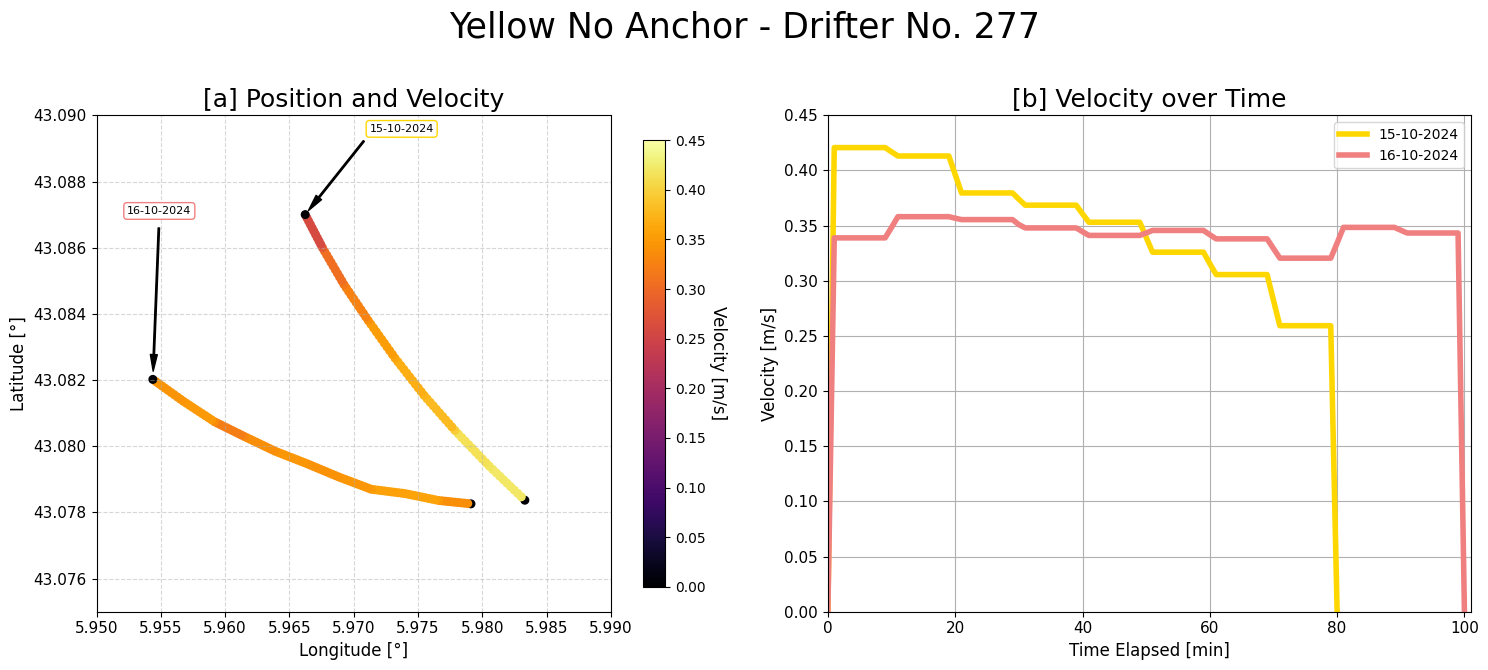

In [67]:
## Create velocity subplots
# Define plot parameters
title = 'Yellow No Anchor - Drifter No. 277'
map_boundary = [5.95, 5.99, 43.075, 43.090]

# Create subplots: one for the map plot and one for the velocity plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))  # Adjust size as needed

# Add a suptitle (overall title)
fig.suptitle(title, fontsize=25, y=0.95)  # Adjust `fontsize` and `y` (vertical position) as needed

# Map Plot (ax1)
# Set the boundaries for the map (just using latitude and longitude for regular plots)
ax1.set_xlim(map_boundary[0], map_boundary[1])
ax1.set_ylim(map_boundary[2], map_boundary[3])

# Plot each drifter's positions with color coding based on velocity
scatter1 = ax1.scatter(
    yellow_no_anchor_15['long'],
    yellow_no_anchor_15['lat'],
    c=yellow_no_anchor_15['Velocities'],
    cmap='inferno',
    marker='o',
    s=30,
    vmin = 0,
    vmax = 0.45
)
ax1.annotate(
    '15-10-2024',
    xy=(yellow_no_anchor_15['long'].iloc[-1], yellow_no_anchor_15['lat'].iloc[-1]),
    xytext=(yellow_no_anchor_15['long'].iloc[-1] + 0.005, yellow_no_anchor_15['lat'].iloc[-1] + 0.0025),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='gold', facecolor='white')
)

scatter2 = ax1.scatter(
    yellow_no_anchor_16['long'],
    yellow_no_anchor_16['lat'],
    c=yellow_no_anchor_16['Velocities'],
    cmap='inferno',
    marker='o',
    s=30,
    vmin = 0,
    vmax = 0.45
)
ax1.annotate(
    '16-10-2024',
    xy=(yellow_no_anchor_16['long'].iloc[-1], yellow_no_anchor_16['lat'].iloc[-1]),
    xytext=(yellow_no_anchor_16['long'].iloc[-1] - 0.002, yellow_no_anchor_16['lat'].iloc[-1] + 0.005),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='lightcoral', facecolor='white')
)


# Add gridlines and labels for the map
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.tick_params(axis='both', which='major', labelsize=11)  # Adjust major tick label size
ax1.set_xlabel('Longitude [°]', size = 12)
ax1.set_ylabel('Latitude [°]', size = 12)
ax1.set_title('[a] Position and Velocity', size = 18)

# Add a colorbar for the velocities
cbar = fig.colorbar(scatter1, ax=ax1, shrink=0.9, pad=0.05)
cbar.set_label('Velocity [m/s]', rotation=-90, labelpad=15, size = 12)

# Velocity Plot (ax2)
# Prepare the velocity time data
index_array_yellownoanchor15 = np.arange(len(yellow_no_anchor_15['Time']))
index_array_yellownoanchor16 = np.arange(len(yellow_no_anchor_16['Time']))


# Find the length of each array
len_yellownoanchor15 = len(yellow_no_anchor_15['Time'])
len_yellownoanchor16 = len(yellow_no_anchor_16['Time'])

# Compare lengths
max_length = max(len_yellownoanchor15, len_yellownoanchor16,)


ax2.plot(index_array_yellownoanchor15, yellow_no_anchor_15['Velocities'], linewidth = 4, color = 'gold', label='15-10-2024')
ax2.plot(index_array_yellownoanchor16, yellow_no_anchor_16['Velocities'], linewidth = 4, color = 'lightcoral', label='16-10-2024')
ax2.tick_params(axis='both', which='major', labelsize=11)  # Adjust major tick label size
ax2.set_xlabel('Time Elapsed [min]', size = 12)
ax2.set_ylabel('Velocity [m/s]', size = 12)
ax2.set_title('[b] Velocity over Time', size = 18)
ax2.set_xlim(0, max_length)
ax2.set_ylim(0, 0.45)
ax2.grid(True)
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the suptitle
plt.savefig('yellownoanchor', dpi=300, bbox_inches='tight')
plt.show()


## Plot speeds of different drifters for each day

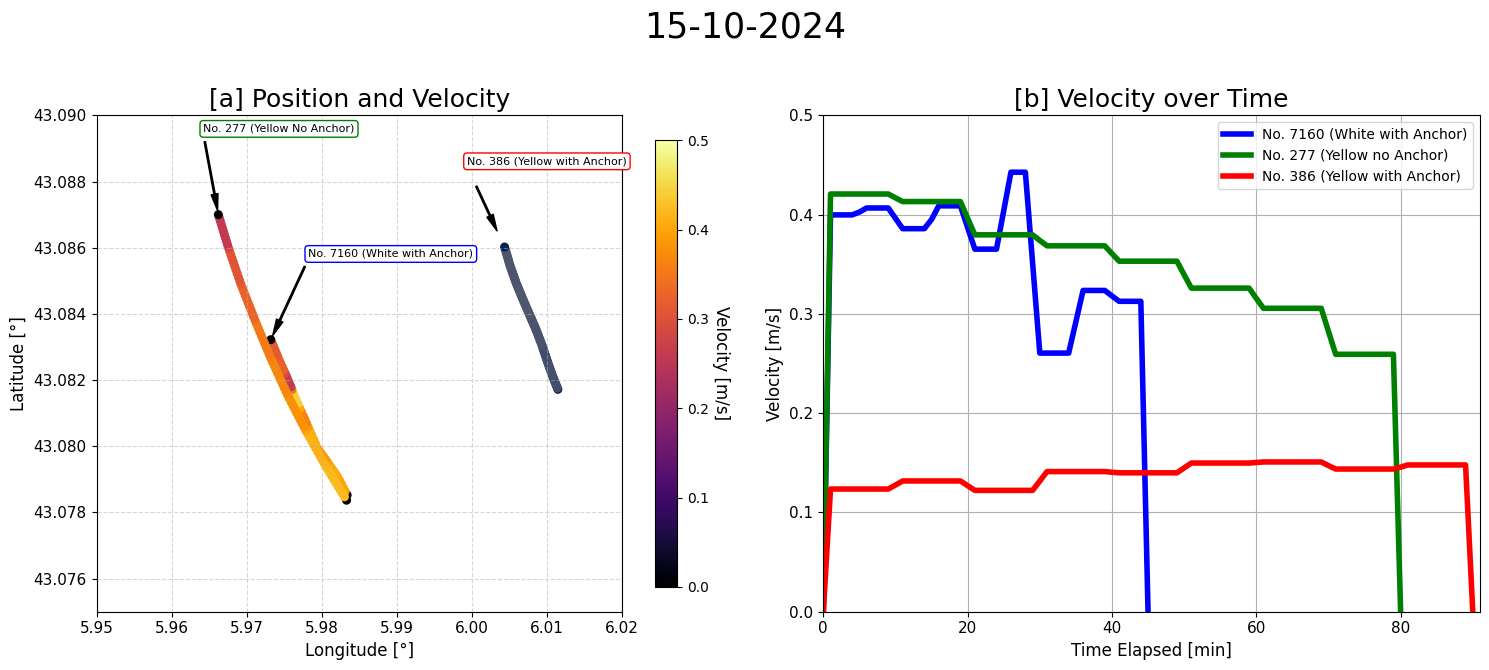

In [68]:
# Define plot parameters
title = '15-10-2024'
map_boundary = [5.95, 6.02, 43.075, 43.090]

# Create subplots: one for the map plot and one for the velocity plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))  # Adjust size as needed

# Add a suptitle (overall title)
fig.suptitle(title, fontsize=25, y=0.95)  # Adjust `fontsize` and `y` (vertical position) as needed

# Map Plot (ax1)
# Set the boundaries for the map (just using latitude and longitude for regular plots)
ax1.set_xlim(map_boundary[0], map_boundary[1])
ax1.set_ylim(map_boundary[2], map_boundary[3])

# Plot each drifter's positions with color coding based on velocity
scatter1 = ax1.scatter(
    white_anchor_15['long'],
    white_anchor_15['lat'],
    c=white_anchor_15['Velocities'],
    cmap='inferno',
    marker='o',
    s=30,
    vmin = 0,
    vmax = 0.50
)
ax1.annotate(
    'No. 7160 (White with Anchor)',
    xy=(white_anchor_15['long'].iloc[-1], white_anchor_15['lat'].iloc[-1]),
    xytext=(white_anchor_15['long'].iloc[-1] + 0.005, white_anchor_15['lat'].iloc[-1] + 0.0025),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='white')
)

scatter2 = ax1.scatter(
    yellow_no_anchor_15['long'],
    yellow_no_anchor_15['lat'],
    c=yellow_no_anchor_15['Velocities'],
    cmap='inferno',
    marker='o',
    s=30,
    vmin = 0,
    vmax = 0.50
)
ax1.annotate(
    'No. 277 (Yellow No Anchor)',
    xy=(yellow_no_anchor_15['long'].iloc[-1], yellow_no_anchor_15['lat'].iloc[-1]),
    xytext=(yellow_no_anchor_15['long'].iloc[-1] - 0.002, yellow_no_anchor_15['lat'].iloc[-1] + 0.0025),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='white')
)

scatter3 = ax1.scatter(
    yellow_anchor_15['long'],
    yellow_anchor_15['lat'],
    c=yellow_anchor_15['Velocities'],
    cmap='cividis',
    marker='o',
    s=30,
    vmin = 0,
    vmax = 0.50
)
ax1.annotate(
    'No. 386 (Yellow with Anchor)',
    xy=(yellow_anchor_15['long'].iloc[-1], yellow_anchor_15['lat'].iloc[-1]),
    xytext=(yellow_anchor_15['long'].iloc[-1] - 0.005, yellow_anchor_15['lat'].iloc[-1] + 0.0025),
    arrowprops=dict(facecolor='black', shrink=0.2, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white')
)

# Add gridlines and labels for the map
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.tick_params(axis='both', which='major', labelsize=11)  # Adjust major tick label size
ax1.set_xlabel('Longitude [°]', size = 12)
ax1.set_ylabel('Latitude [°]', size = 12)
ax1.set_title('[a] Position and Velocity', size = 18)

# Add a colorbar for the velocities
cbar = fig.colorbar(scatter1, ax=ax1, shrink=0.9, pad=0.05)
cbar.set_label('Velocity [m/s]', rotation=-90, labelpad=15, size = 12)

# Velocity Plot (ax2)
# Prepare the velocity time data
index_array_whiteanchor15 = np.arange(len(white_anchor_15['Time']))
index_array_yellownoanchor15 = np.arange(len(yellow_no_anchor_15['Time']))
index_array_yellowanchor15 = np.arange(len(yellow_anchor_15['Time']))

# Find the length of each array
len_whiteanchor15 = len(white_anchor_15['Time'])
len_yellownoanchor15 = len(yellow_no_anchor_15['Time'])
len_yellowanchor15 = len(yellow_anchor_15['Time'])

# Compare lengths
max_length = max(len_whiteanchor15, len_yellownoanchor15, len_yellowanchor15)


ax2.plot(index_array_whiteanchor15, white_anchor_15['Velocities'], linewidth = 4, color = 'blue', label='No. 7160 (White with Anchor)')
ax2.plot(index_array_yellownoanchor15, yellow_no_anchor_15['Velocities'], linewidth = 4, color = 'green', label='No. 277 (Yellow no Anchor)')
ax2.plot(index_array_yellowanchor15, yellow_anchor_15['Velocities'], linewidth = 4, color = 'red',label='No. 386 (Yellow with Anchor)')
ax2.tick_params(axis='both', which='major', labelsize=11)  # Adjust major tick label size
ax2.set_xlabel('Time Elapsed [min]', size = 12)
ax2.set_ylabel('Velocity [m/s]', size = 12)
ax2.set_title('[b] Velocity over Time', size = 18)
ax2.set_xlim(0, max_length)
ax2.set_ylim(0,0.50)
ax2.grid(True)
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the suptitle
plt.savefig('15speeds', dpi=300, bbox_inches='tight')
plt.show()

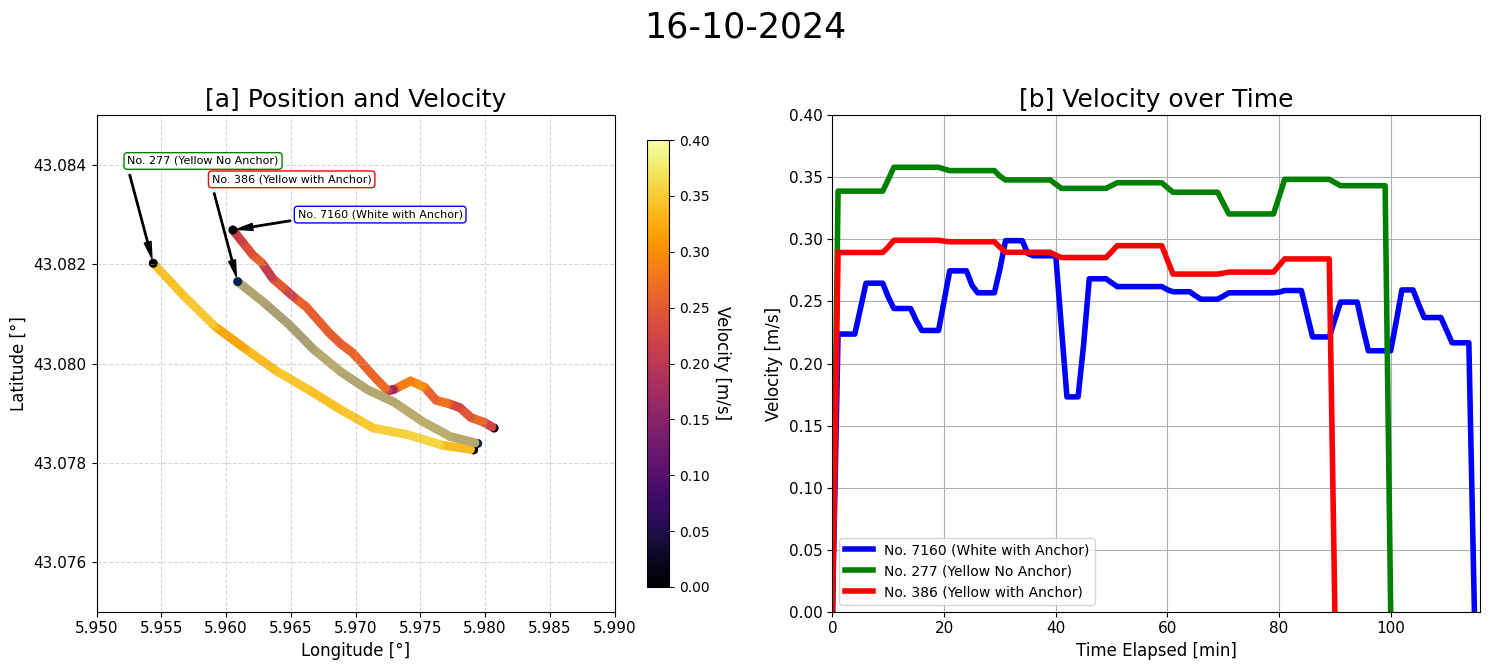

In [69]:
# Define plot parameters
title = '16-10-2024'
map_boundary = [5.95, 5.99, 43.075, 43.085]
# Create subplots: one for the map plot and one for the velocity plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))  # Adjust size as needed

# Add a suptitle (overall title)
fig.suptitle(title, fontsize=25, y=0.95)  # Adjust `fontsize` and `y` (vertical position) as needed

# Map Plot (ax1)
# Set the boundaries for the map (just using latitude and longitude for regular plots)
ax1.set_xlim(map_boundary[0], map_boundary[1])
ax1.set_ylim(map_boundary[2], map_boundary[3])

# Plot each drifter's positions with color coding based on velocity
scatter1 = ax1.scatter(
    white_anchor_16['long'],
    white_anchor_16['lat'],
    c=white_anchor_16['Velocities'],
    cmap='inferno',
    marker='o',
    s=30,
    vmin = 0,
    vmax = 0.40
)
ax1.annotate(
    'No. 7160 (White with Anchor)',
    xy=(white_anchor_16['long'].iloc[-1], white_anchor_16['lat'].iloc[-1]),
    xytext=(white_anchor_16['long'].iloc[-1] + 0.005, white_anchor_16['lat'].iloc[-1] + 0.00025),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='white')
)


scatter2 = ax1.scatter(
    yellow_no_anchor_16['long'],
    yellow_no_anchor_16['lat'],
    c=yellow_no_anchor_16['Velocities'],
    cmap='inferno',
    marker='o',
    s=30,
    vmin = 0,
    vmax = 0.40
)
ax1.annotate(
    'No. 277 (Yellow No Anchor)',
    xy=(yellow_no_anchor_16['long'].iloc[-1], yellow_no_anchor_16['lat'].iloc[-1]),
    xytext=(yellow_no_anchor_16['long'].iloc[-1] - 0.002, yellow_no_anchor_16['lat'].iloc[-1] + 0.002),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='green', facecolor='white')
)

scatter3 = ax1.scatter(
    yellow_anchor_16['long'],
    yellow_anchor_16['lat'],
    c=yellow_anchor_16['Velocities'],
    cmap='cividis',
    marker='o',
    s=30,
    vmin = 0,
    vmax = 0.40
)

ax1.annotate(
'No. 386 (Yellow with Anchor)',
xy=(yellow_anchor_16['long'].iloc[-1], yellow_anchor_16['lat'].iloc[-1]),
xytext=(yellow_anchor_16['long'].iloc[-1] - 0.002, yellow_anchor_16['lat'].iloc[-1] + 0.002),
arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
fontsize=8,
bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white')
)
# Add gridlines and labels for the map
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.tick_params(axis='both', which='major', labelsize=11)  # Adjust major tick label size
ax1.set_xlabel('Longitude [°]', size = 12)
ax1.set_ylabel('Latitude [°]', size = 12)
ax1.set_title('[a] Position and Velocity', size = 18)

# Add a colorbar for the velocities
cbar = fig.colorbar(scatter1, ax=ax1, shrink=0.9, pad=0.05)
cbar.set_label('Velocity [m/s]', rotation=-90, labelpad=15, size = 12)

# Velocity Plot (ax2)
# Prepare the velocity time data
index_array_whiteanchor16 = np.arange(len(white_anchor_16['Time']))
index_array_yellownoanchor16 = np.arange(len(yellow_no_anchor_16['Time']))
index_array_yellowanchor16 = np.arange(len(yellow_anchor_16['Time']))

# Find the length of each array
len_whiteanchor16 = len(white_anchor_16['Time'])
len_yellownoanchor16 = len(yellow_no_anchor_16['Time'])
len_yellowanchor16 = len(yellow_anchor_16['Time'])

# Compare lengths
max_length = max(len_whiteanchor16, len_yellownoanchor16, len_yellowanchor16)


ax2.plot(index_array_whiteanchor16, white_anchor_16['Velocities'], linewidth = 4, color = 'blue', label='No. 7160 (White with Anchor)')
ax2.plot(index_array_yellownoanchor16, yellow_no_anchor_16['Velocities'], linewidth = 4, color = 'green', label='No. 277 (Yellow No Anchor)')
ax2.plot(index_array_yellowanchor16, yellow_anchor_16['Velocities'], linewidth = 4, color = 'red',label='No. 386 (Yellow with Anchor)')
ax2.tick_params(axis='both', which='major', labelsize=11)  # Adjust major tick label size
ax2.set_xlabel('Time Elapsed [min]', size = 12)
ax2.set_ylabel('Velocity [m/s]', size = 12)
ax2.set_title('[b] Velocity over Time', size = 18)
ax2.set_xlim(0, max_length)
ax2.set_ylim(0,0.40)
ax2.grid(True)
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the suptitle
plt.savefig('16speeds', dpi=300, bbox_inches='tight')
plt.show()

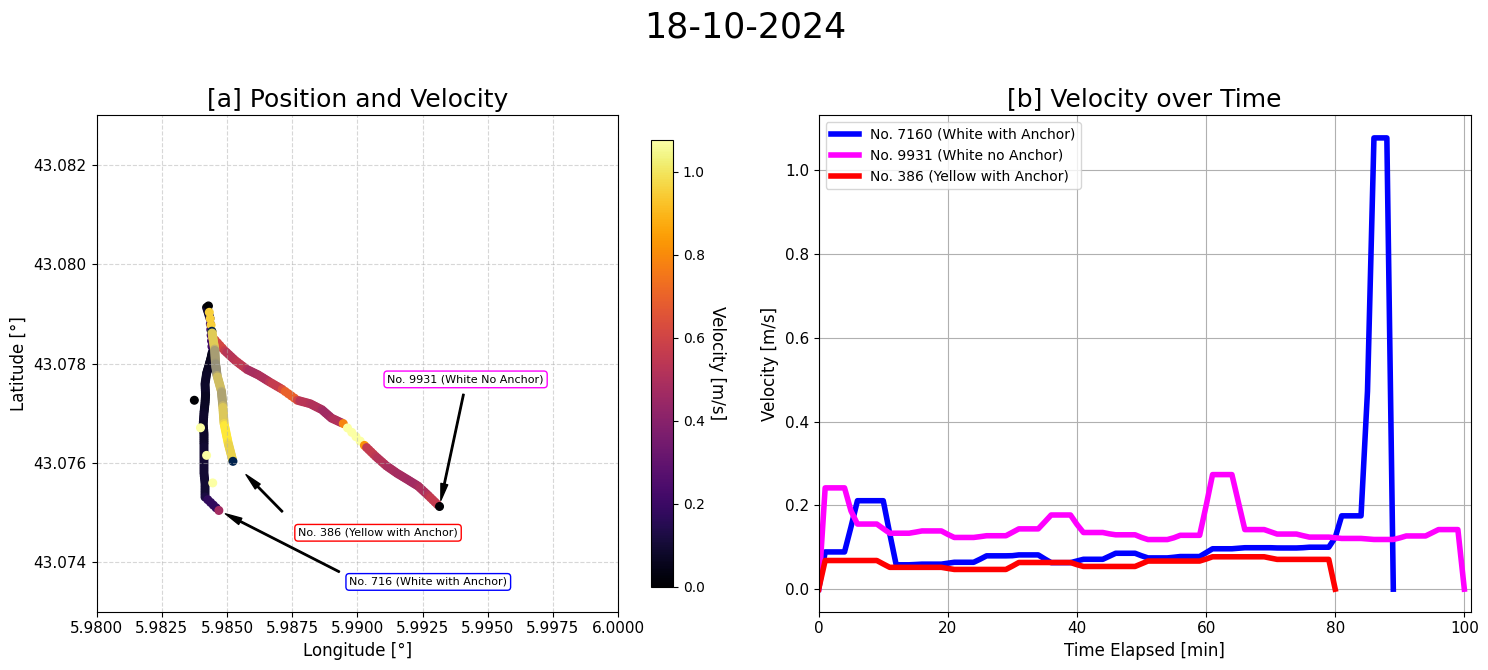

In [70]:
# Define plot parameters
title = '18-10-2024'
map_boundary = [5.98, 6.00, 43.073, 43.083]

# Create subplots: one for the map plot and one for the velocity plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))  # Adjust size as needed

# Add a suptitle (overall title)
fig.suptitle(title, fontsize=25, y=0.95)  # Adjust `fontsize` and `y` (vertical position) as needed

# Map Plot (ax1)
# Set the boundaries for the map (just using latitude and longitude for regular plots)
ax1.set_xlim(map_boundary[0], map_boundary[1])
ax1.set_ylim(map_boundary[2], map_boundary[3])

# Plot each drifter's positions with color coding based on velocity
scatter1 = ax1.scatter(
    white_anchor_18['long'],
    white_anchor_18['lat'],
    c=white_anchor_18['Velocities'],
    cmap='inferno',
    marker='o',
    s=30,
    vmin = 0,
    #vmax = 0.12
)
ax1.annotate(
    'No. 716 (White with Anchor)',
    xy=(white_anchor_18['long'].iloc[-5], white_anchor_18['lat'].iloc[-5]),
    xytext=(white_anchor_18['long'].iloc[-5] + 0.005, white_anchor_18['lat'].iloc[-5] - 0.0015),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='blue', facecolor='white')
)

scatter2 = ax1.scatter(
    white_no_anchor_18['long'],
    white_no_anchor_18['lat'],
    c=white_no_anchor_18['Velocities'],
    cmap='inferno',
    marker='o',
    s=30,
    vmin = 0,
    #vmax = 0.12
)
ax1.annotate(
    'No. 9931 (White No Anchor)',
    xy=(white_no_anchor_18['long'].iloc[-1], white_no_anchor_18['lat'].iloc[-1]),
    xytext=(white_no_anchor_18['long'].iloc[-1] - 0.002, white_no_anchor_18['lat'].iloc[-1] + 0.0025),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='magenta', facecolor='white')
)

scatter3 = ax1.scatter(
    yellow_anchor_18['long'],
    yellow_anchor_18['lat'],
    c=yellow_anchor_18['Velocities'],
    cmap='cividis',
    marker='o',
    s=30,
    vmin = 0,
    #vmax = 0.12
)
ax1.annotate(
    'No. 386 (Yellow with Anchor)',
    xy=(yellow_anchor_18['long'].iloc[-1], yellow_anchor_18['lat'].iloc[-1]),
    xytext=(yellow_anchor_18['long'].iloc[-1] + 0.0025, yellow_anchor_18['lat'].iloc[-1] - 0.0015),
    arrowprops=dict(facecolor='black', shrink=0.2, width=1, headwidth=5),
    fontsize=8,
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white')
)

# Add gridlines and labels for the map
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.tick_params(axis='both', which='major', labelsize=11)  # Adjust major tick label size
ax1.set_xlabel('Longitude [°]', size = 12)
ax1.set_ylabel('Latitude [°]', size = 12)
ax1.set_title('[a] Position and Velocity', size = 18)

# Add a colorbar for the velocities
cbar = fig.colorbar(scatter1, ax=ax1, shrink=0.9, pad=0.05)
cbar.set_label('Velocity [m/s]', rotation=-90, labelpad=15, size = 12)

# Velocity Plot (ax2)
# Prepare the velocity time data
index_array_whiteanchor18 = np.arange(len(white_anchor_18['Time']))
index_array_whitenoanchor18 = np.arange(len(white_no_anchor_18['Time']))
index_array_yellowanchor18 = np.arange(len(yellow_anchor_18['Time']))

# Find the length of each array
len_whiteanchor18 = len(white_anchor_18['Time'])
len_whitenoanchor18 = len(white_no_anchor_18['Time'])
len_yellowanchor18 = len(yellow_anchor_18['Time'])

# Compare lengths
max_length = max(len_whiteanchor18, len_whitenoanchor18, len_yellowanchor18)


ax2.plot(index_array_whiteanchor18, white_anchor_18['Velocities'], linewidth = 4, color = 'blue', label='No. 7160 (White with Anchor)')
ax2.plot(index_array_whitenoanchor18, white_no_anchor_18['Velocities'], linewidth = 4, color = 'magenta', label='No. 9931 (White no Anchor)')
ax2.plot(index_array_yellowanchor18, yellow_anchor_18['Velocities'], linewidth = 4, color = 'red',label='No. 386 (Yellow with Anchor)')
ax2.tick_params(axis='both', which='major', labelsize=11)  # Adjust major tick label size
ax2.set_xlabel('Time Elapsed [min]', size = 12)
ax2.set_ylabel('Velocity [m/s]', size = 12)
ax2.set_title('[b] Velocity over Time', size = 18)
ax2.set_xlim(0, max_length)
#ax2.set_ylim(0,0.12)
ax2.grid(True)
ax2.legend()

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave space for the suptitle
plt.savefig('18speeds', dpi=300, bbox_inches='tight')
plt.show()

## Calculate mean drifter velocities

In [71]:
mean_whiteanchor15 = white_anchor_15['Velocities'].mean()
mean_yellownoanchor15 = yellow_no_anchor_15['Velocities'].mean()
mean_yellowanchor15 = yellow_anchor_15['Velocities'].mean()


mean_whiteanchor16 = white_anchor_16['Velocities'].mean()
mean_yellownoanchor16 = yellow_no_anchor_16['Velocities'].mean()
mean_yellowanchor16 = yellow_anchor_16['Velocities'].mean()

mean_whiteanchor18 = white_anchor_18['Velocities'].mean()
mean_whitenoanchor18 = white_no_anchor_18['Velocities'].mean()
mean_yellowanchor18 = yellow_anchor_18['Velocities'].mean()

## Plot drifter positions with annotation

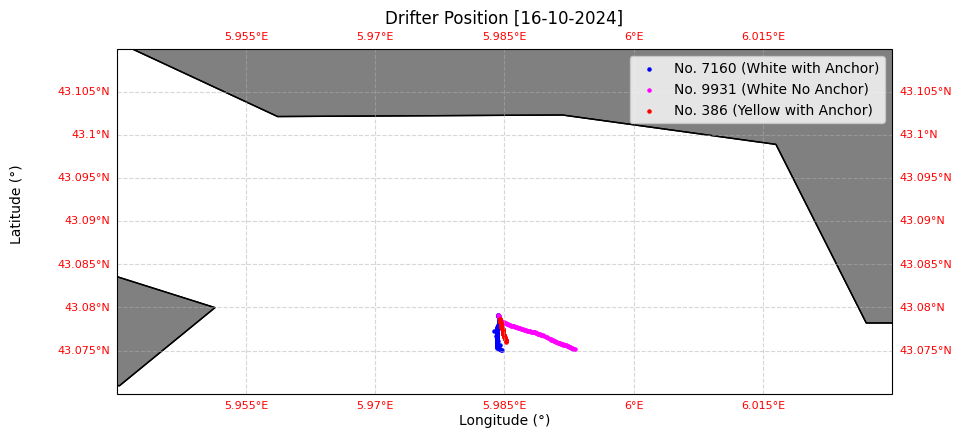

In [72]:
# Drifters positions
colors = ['blue', 'magenta', 'red']  # Colors for each drifter
labels = ['No. 7160 (White with Anchor)', 'No. 9931 (White No Anchor)', 'No. 386 (Yellow with Anchor)']
#map_boundary=[5.94, 5.985, 43.07, 43.11]
map_boundary=[5.94, 6.03, 43.07, 43.11]
title='Drifter Position [16-10-2024]'
filename = 'drifters_positions_16-10-2024.png'
plot_drifter_positions(all_drifters_18, colors, labels,map_boundary,title)

<ipython-input-57-85c43c678019>:351: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interp_u = interp2d(lon, lat, u_wind, kind='cubic')
<ipython-input-57-85c43c678019>:352: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or


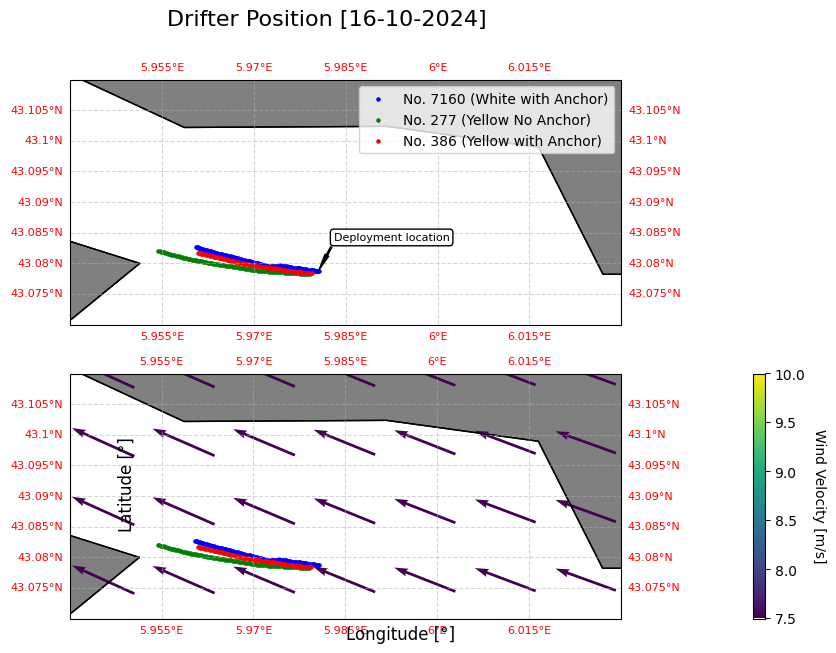

In [73]:
# Drifters positions 16-10-2024
colors = ['blue', 'green', 'red']  # Colors for each drifter
labels = ['No. 7160 (White with Anchor)', 'No. 277 (Yellow No Anchor)', 'No. 386 (Yellow with Anchor)']
#map_boundary=[5.94, 5.985, 43.07, 43.11]
map_boundary=[5.94, 6.03, 43.07, 43.11]
lat_min, lat_max = 42, 43.11  # Latitude range
lon_min, lon_max = 5, 6.3  # Longitude range
title='Drifter Position [16-10-2024]'
filename = 'drifters_positions_withwind_16_6AM.png'
plot_drifter_positions_with_wind_subplot(
    all_drifters_16, colors, labels, map_boundary, title, wind_data,
    lat_min, lat_max, lon_min, lon_max, filename)

In [74]:
## Special function for 15-10-2024 because deployment locations are far apart
def plot_drifter_positions_with_wind_subplot15(
    all_drifters, colors, labels, map_boundary, title, wind_data,
    lat_min, lat_max, lon_min, lon_max, filename):

      # Create figure with 2 subplots
      fig, axes = plt.subplots(
          nrows=2, ncols=1, figsize=(15, 7),
          subplot_kw={'projection': ccrs.PlateCarree()}
      )

      # First subplot: Drifter positions
      ax1 = axes[0]
      ax1.coastlines()
      ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor='grey')
      ax1.add_feature(cfeature.BORDERS, linestyle=':')
      ax1.set_extent(map_boundary, crs=ccrs.PlateCarree())

      for drifter, color, label in zip(all_drifters, colors, labels):
          interpolated_long = drifter['long']
          interpolated_lat = drifter['lat']
          velocities = drifter['Velocities']

          if len(interpolated_long) == len(interpolated_lat) and len(velocities) == len(interpolated_long):
              ax1.scatter(
                  interpolated_long, interpolated_lat, color=color, marker='o',
                  s=5, transform=ccrs.PlateCarree(), label=label
              )
          else:
              print(f"Error: Data lengths do not match for {label}")

      ax1.annotate(
          'Deployment location',
          xy=(all_drifters[0]['long'][1], all_drifters[0]['lat'][1]),
          xytext=(all_drifters[0]['long'][1] + 0.0025, all_drifters[0]['lat'][1] - 0.008),
          arrowprops=dict(facecolor='black', shrink=0.04, width=1, headwidth=3),
          fontsize=8, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
      )

      ax1.annotate(
          'Deployment location',
          xy=(all_drifters[2]['long'][1], all_drifters[2]['lat'][1]),
          xytext=(all_drifters[2]['long'][1] + 0.0025, all_drifters[2]['lat'][1] - 0.01),
          arrowprops=dict(facecolor='black', shrink=0.04, width=1, headwidth=3),
          fontsize=8, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white')
      )

      gridlines = ax1.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
      gridlines.xlabel_style = {'size': 8, 'color': 'red'}
      gridlines.ylabel_style = {'size': 8, 'color': 'red'}
      gridlines.xformatter = LongitudeFormatter(degree_symbol="°")
      gridlines.yformatter = LatitudeFormatter(degree_symbol="°")

      ax1.legend()

      # Second subplot: Wind data
      ax2 = axes[1]
      ax2.coastlines()
      ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor='grey')
      ax2.add_feature(cfeature.BORDERS, linestyle=':')
      ax2.set_extent(map_boundary, crs=ccrs.PlateCarree())

      # Subset the wind data for the region of interest
      toulon_data = wind_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
      u_wind = toulon_data['u_wind'].isel(time=2, zlev=0).values
      v_wind = toulon_data['v_wind'].isel(time=2, zlev=0).values
      lat = toulon_data['lat'].values
      lon = toulon_data['lon'].values

      # Interpolation
      num_points = 100
      lat_fine = np.linspace(lat_min, lat_max, num_points)
      lon_fine = np.linspace(lon_min, lon_max, num_points)
      interp_u = interp2d(lon, lat, u_wind, kind='cubic')
      interp_v = interp2d(lon, lat, v_wind, kind='cubic')
      u_wind_fine = interp_u(lon_fine, lat_fine)
      v_wind_fine = interp_v(lon_fine, lat_fine)
      wind_speed = np.sqrt(u_wind_fine**2 + v_wind_fine**2)
      lon_grid_fine, lat_grid_fine = np.meshgrid(lon_fine, lat_fine)

      # Define the color normalization range
      norm = Normalize(vmin=7.5, vmax=10)  # Adjust vmin and vmax as needed

      # Create the quiver plot with normalized colors
      quiver = ax2.quiver(
          lon_grid_fine, lat_grid_fine, u_wind_fine, v_wind_fine, wind_speed,
          transform=ccrs.PlateCarree(), scale=50, pivot='middle', cmap='viridis',
          width=0.005, norm=norm  # Apply the normalization
      )

      # Add a colorbar
      cbar = plt.colorbar(
          quiver,
          ax=ax2,
          orientation='vertical',
          pad=0.01,
      )
      cbar.set_label('Wind Velocity [m/s]', rotation=-90, labelpad=15, size=10)

      # Loop through all drifters and plot them on the same map
      for drifter, color, label in zip(all_drifters, colors, labels):
          # Assuming drifter has attributes: `long`, `lat`, and `velocities`
          interpolated_long = drifter['long']
          interpolated_lat = drifter['lat']
          velocities = drifter['Velocities']

          # Normalize velocities for consistent scaling (optional, not used here)
          if len(interpolated_long) == len(interpolated_lat) and len(velocities) == len(interpolated_long):
              scatter = ax2.scatter(
                  interpolated_long,
                  interpolated_lat,
                  color=color,  # Use fixed color for the drifter
                  marker='o',
                  s=5,
                  transform=ccrs.PlateCarree(),
                  label=label
              )
          else:
              print(f"Error: Data lengths do not match for {label}")

      # Add gridlines with degree labels
      gridlines = ax2.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
      gridlines.xlabel_style = {'size': 8, 'color': 'red'}
      gridlines.ylabel_style = {'size': 8, 'color': 'red'}
      gridlines.xformatter = LongitudeFormatter(degree_symbol="°")
      gridlines.yformatter = LatitudeFormatter(degree_symbol="°")

      # Add title and labels
      ax2.text(0.12, 0.55, 'Latitude [°]', size=12, va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform=ax2.transAxes)
      ax2.text(0.6, -0.1, 'Longitude [°]', size=12, va='bottom', ha='center', rotation='horizontal', rotation_mode='anchor', transform=ax2.transAxes)
      ax2.set_aspect('equal')
      # Get the current position of ax2
      pos = ax2.get_position().bounds  # (x0, y0, width, height)

      # Adjust the x-coordinate (x0) to shift left
      new_pos = [pos[0] - 0.08, pos[1], pos[2], pos[3]]  # Decrease x0 by 0.02

      # Apply the new position to ax2
      ax2.set_position(new_pos)



      # Overall title
      fig.suptitle(title, fontsize=16)

      # Save the figure
      plt.savefig(filename, dpi=300)
      plt.show()


<ipython-input-74-8745f26c0c76>:74: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interp_u = interp2d(lon, lat, u_wind, kind='cubic')
<ipython-input-74-8745f26c0c76>:75: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`C

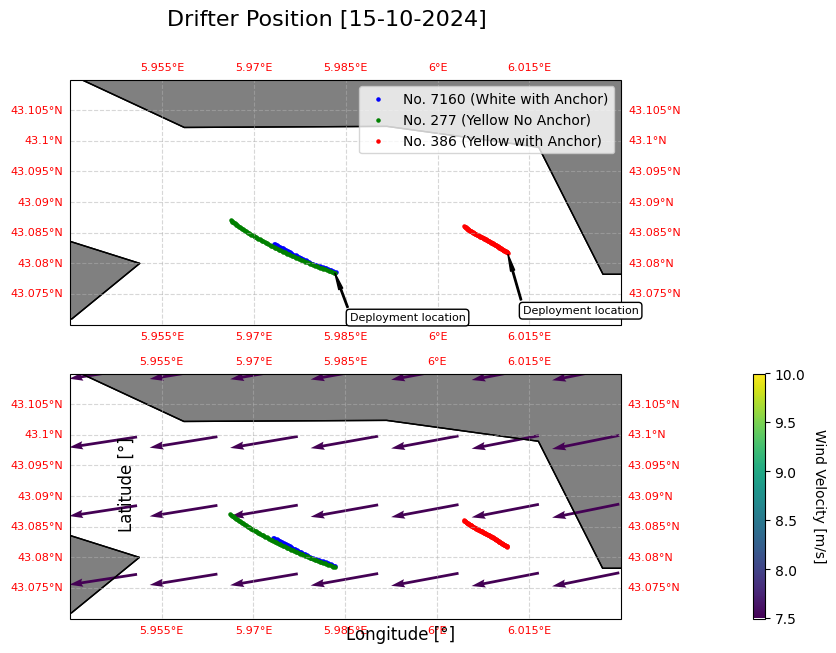

In [75]:
# Drifters positions 15-10-2024
colors = ['blue', 'green', 'red']  # Colors for each drifter
labels = ['No. 7160 (White with Anchor)', 'No. 277 (Yellow No Anchor)', 'No. 386 (Yellow with Anchor)']
#map_boundary=[5.94, 5.985, 43.07, 43.11]
map_boundary=[5.94, 6.03, 43.07, 43.11]
title='Drifter Position [15-10-2024]'
filename = 'drifters_positions_15-10-2024.png'
plot_drifter_positions_with_wind_subplot15(
    all_drifters_15, colors, labels, map_boundary, title, wind_data15,
    lat_min, lat_max, lon_min, lon_max, filename)